In [1]:
import keras

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15762358017460023305
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6777022874
locality {
  bus_id: 1
}
incarnation: 12318789474969748614
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 6777128715
locality {
  bus_id: 1
}
incarnation: 14840326828266827311
physical_device_desc: "device: 1, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [1]:
'''Visualization of the filters of VGG16, via gradient ascent in input space.
This script can run on CPU in a few minutes.
Results example: http://i.imgur.com/4nj4KjN.jpg
'''
from __future__ import print_function

from imageio import imwrite
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
for filter_index in range(200):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imwrite('stitched_filters_%dx%d.png' % (n, n), stitched_filters)


Using TensorFlow backend.


Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0      

Current loss value: 17.2367
Current loss value: 55.8085
Current loss value: 63.4348
Current loss value: 116.143
Current loss value: 162.883
Current loss value: 224.877
Current loss value: 279.031
Current loss value: 330.63
Current loss value: 380.572
Current loss value: 435.099
Current loss value: 477.553
Current loss value: 535.598
Current loss value: 572.131
Current loss value: 624.993
Current loss value: 655.091
Current loss value: 713.512
Current loss value: 749.299
Current loss value: 781.363
Current loss value: 825.255
Current loss value: 876.332
Filter 9 processed in 0s
Processing filter 10
Current loss value: 9.68565
Current loss value: 11.473
Current loss value: 21.4346
Current loss value: 52.398
Current loss value: 90.1068
Current loss value: 115.238
Current loss value: 165.004
Current loss value: 207.504
Current loss value: 244.311
Current loss value: 288.39
Current loss value: 327.9
Current loss value: 371.377
Current loss value: 402.702
Current loss value: 443.999
Current 

Current loss value: 1.09955
Current loss value: 21.2601
Current loss value: 76.4955
Current loss value: 143.6
Current loss value: 202.305
Current loss value: 268.611
Current loss value: 318.708
Current loss value: 362.258
Current loss value: 410.393
Current loss value: 450.527
Current loss value: 488.385
Current loss value: 532.692
Current loss value: 573.005
Current loss value: 615.564
Current loss value: 655.185
Current loss value: 694.153
Current loss value: 735.016
Current loss value: 770.156
Current loss value: 812.579
Current loss value: 851.338
Filter 28 processed in 0s
Processing filter 29
Current loss value: 40.8139
Current loss value: 63.5114
Current loss value: 102.823
Current loss value: 165.231
Current loss value: 229.005
Current loss value: 258.22
Current loss value: 364.545
Current loss value: 388.479
Current loss value: 464.735
Current loss value: 501.22
Current loss value: 558.833
Current loss value: 612.065
Current loss value: 663.955
Current loss value: 711.809
Curre

Current loss value: 569.894
Current loss value: 604.411
Current loss value: 642.435
Current loss value: 676.957
Current loss value: 714.439
Current loss value: 747.637
Filter 44 processed in 0s
Processing filter 45
Current loss value: 0.884225
Current loss value: 32.302
Current loss value: 86.5984
Current loss value: 153.086
Current loss value: 210.04
Current loss value: 265.187
Current loss value: 314.271
Current loss value: 358.636
Current loss value: 398.988
Current loss value: 439.26
Current loss value: 475.12
Current loss value: 510.554
Current loss value: 544.984
Current loss value: 578.263
Current loss value: 614.391
Current loss value: 649.207
Current loss value: 681.122
Current loss value: 713.328
Current loss value: 741.724
Current loss value: 772.745
Filter 45 processed in 0s
Processing filter 46
Current loss value: 0.988152
Current loss value: 5.228
Current loss value: 13.4728
Current loss value: 41.7051
Current loss value: 92.7054
Current loss value: 153.674
Current loss v

Current loss value: 6.63795
Current loss value: 60.0125
Current loss value: 114.531
Current loss value: 151.581
Current loss value: 193.668
Current loss value: 234.413
Current loss value: 277.766
Current loss value: 315.219
Current loss value: 358.293
Current loss value: 404.796
Current loss value: 447.489
Current loss value: 477.602
Current loss value: 513.243
Current loss value: 550.559
Current loss value: 586.791
Current loss value: 620.142
Current loss value: 659.007
Current loss value: 695.755
Current loss value: 736.637
Current loss value: 774.681
Filter 62 processed in 0s
Processing filter 63
Current loss value: 0.0
Filter 63 processed in 0s
Processing filter 64
Current loss value: 0.194499
Current loss value: 23.3928
Current loss value: 90.9601
Current loss value: 193.263
Current loss value: 294.16
Current loss value: 395.466
Current loss value: 493.911
Current loss value: 578.364
Current loss value: 679.427
Current loss value: 769.485
Current loss value: 857.401
Current loss v

Current loss value: 9.35361
Current loss value: 54.686
Current loss value: 110.436
Current loss value: 187.661
Current loss value: 249.646
Current loss value: 301.229
Current loss value: 361.647
Current loss value: 441.024
Current loss value: 513.167
Current loss value: 577.513
Current loss value: 646.239
Current loss value: 709.533
Current loss value: 781.355
Current loss value: 833.502
Current loss value: 896.327
Current loss value: 961.689
Current loss value: 1021.33
Current loss value: 1083.67
Current loss value: 1141.99
Current loss value: 1201.97
Filter 82 processed in 0s
Processing filter 83
Current loss value: 0.0
Filter 83 processed in 0s
Processing filter 84
Current loss value: 13.0357
Current loss value: 8.32789
Current loss value: 55.0509
Current loss value: 60.413
Current loss value: 106.816
Current loss value: 151.114
Current loss value: 205.579
Current loss value: 234.164
Current loss value: 306.528
Current loss value: 336.474
Current loss value: 400.914
Current loss val

Current loss value: 549.112
Current loss value: 580.269
Filter 101 processed in 0s
Processing filter 102
Current loss value: 0.0118034
Current loss value: 5.82832
Current loss value: 31.0178
Current loss value: 76.7221
Current loss value: 127.003
Current loss value: 200.138
Current loss value: 265.215
Current loss value: 338.048
Current loss value: 400.739
Current loss value: 469.292
Current loss value: 543.471
Current loss value: 620.376
Current loss value: 693.667
Current loss value: 772.578
Current loss value: 851.518
Current loss value: 925.904
Current loss value: 999.684
Current loss value: 1074.88
Current loss value: 1139.13
Current loss value: 1218.67
Filter 102 processed in 0s
Processing filter 103
Current loss value: 0.79864
Current loss value: 10.197
Current loss value: 37.7123
Current loss value: 110.904
Current loss value: 191.176
Current loss value: 288.565
Current loss value: 387.284
Current loss value: 473.883
Current loss value: 557.185
Current loss value: 655.583
Curre

Current loss value: 284.351
Current loss value: 320.113
Current loss value: 364.525
Current loss value: 398.519
Current loss value: 435.984
Current loss value: 468.749
Current loss value: 500.648
Current loss value: 528.081
Filter 122 processed in 0s
Processing filter 123
Current loss value: 0.238158
Current loss value: 0.996528
Current loss value: 7.12358
Current loss value: 17.3814
Current loss value: 30.5854
Current loss value: 47.0147
Current loss value: 69.0936
Current loss value: 94.8879
Current loss value: 124.159
Current loss value: 158.201
Current loss value: 192.64
Current loss value: 230.11
Current loss value: 259.763
Current loss value: 298.109
Current loss value: 332.641
Current loss value: 365.272
Current loss value: 396.672
Current loss value: 428.035
Current loss value: 460.425
Current loss value: 493.059
Filter 123 processed in 1s
Processing filter 124
Current loss value: 0.0
Filter 124 processed in 0s
Processing filter 125
Current loss value: 0.867218
Current loss val

Current loss value: 11.182
Current loss value: 47.3426
Current loss value: 80.6106
Current loss value: 115.424
Current loss value: 157.287
Current loss value: 203.253
Current loss value: 244.901
Current loss value: 281.999
Current loss value: 328.92
Current loss value: 364.734
Current loss value: 415.263
Current loss value: 451.44
Current loss value: 495.239
Current loss value: 535.253
Current loss value: 572.014
Current loss value: 604.922
Current loss value: 648.966
Current loss value: 686.463
Current loss value: 725.092
Current loss value: 758.476
Filter 140 processed in 0s
Processing filter 141
Current loss value: 2.55301
Current loss value: 18.2223
Current loss value: 62.7085
Current loss value: 93.508
Current loss value: 153.831
Current loss value: 197.425
Current loss value: 244.822
Current loss value: 280.419
Current loss value: 330.947
Current loss value: 376.871
Current loss value: 425.526
Current loss value: 471.195
Current loss value: 516.852
Current loss value: 558.581
Cur

Current loss value: 7.10556
Current loss value: 11.3645
Current loss value: 25.0162
Current loss value: 57.3194
Current loss value: 102.641
Current loss value: 153.661
Current loss value: 206.147
Current loss value: 260.843
Current loss value: 320.202
Current loss value: 387.825
Current loss value: 449.284
Current loss value: 507.897
Current loss value: 560.315
Current loss value: 614.271
Current loss value: 666.018
Current loss value: 718.288
Current loss value: 771.395
Current loss value: 824.467
Current loss value: 878.833
Current loss value: 932.895
Filter 158 processed in 0s
Processing filter 159
Current loss value: 84.9204
Current loss value: 96.3245
Current loss value: 119.033
Current loss value: 143.769
Current loss value: 169.69
Current loss value: 193.305
Current loss value: 217.932
Current loss value: 244.319
Current loss value: 260.494
Current loss value: 287.52
Current loss value: 307.276
Current loss value: 334.108
Current loss value: 359.707
Current loss value: 386.253
C

Current loss value: 0.305343
Current loss value: 17.9041
Current loss value: 66.335
Current loss value: 120.472
Current loss value: 182.494
Current loss value: 244.271
Current loss value: 295.295
Current loss value: 349.945
Current loss value: 396.587
Current loss value: 442.778
Current loss value: 492.931
Current loss value: 544.342
Current loss value: 586.231
Current loss value: 635.858
Current loss value: 679.805
Current loss value: 727.467
Current loss value: 770.309
Current loss value: 817.905
Current loss value: 859.996
Current loss value: 908.583
Filter 176 processed in 0s
Processing filter 177
Current loss value: 7.3298
Current loss value: 18.5481
Current loss value: 34.8338
Current loss value: 54.7354
Current loss value: 93.3479
Current loss value: 154.15
Current loss value: 215.691
Current loss value: 271.365
Current loss value: 328.905
Current loss value: 379.349
Current loss value: 427.903
Current loss value: 471.937
Current loss value: 522.76
Current loss value: 572.746
Cu

Current loss value: 427.064
Current loss value: 469.825
Current loss value: 512.382
Current loss value: 551.824
Current loss value: 587.688
Current loss value: 626.828
Current loss value: 662.241
Filter 191 processed in 1s
Processing filter 192
Current loss value: 7.96246
Current loss value: 16.3776
Current loss value: 38.3086
Current loss value: 73.1738
Current loss value: 116.699
Current loss value: 158.611
Current loss value: 197.771
Current loss value: 230.619
Current loss value: 266.209
Current loss value: 308.859
Current loss value: 341.688
Current loss value: 381.871
Current loss value: 418.926
Current loss value: 456.856
Current loss value: 493.119
Current loss value: 529.299
Current loss value: 564.961
Current loss value: 598.459
Current loss value: 631.379
Current loss value: 665.761
Filter 192 processed in 1s
Processing filter 193
Current loss value: 0.0
Filter 193 processed in 0s
Processing filter 194
Current loss value: 0.0
Filter 194 processed in 0s
Processing filter 195


C:\Users\Bob\Anaconda3\envs\keras\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 255.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


In [1]:
%%javascript
// Source - https://stackoverflow.com/a/23395136

Jupyter.beep = () => {
    var snd = new Audio("data:audio/wav;base64,//uQRAAAAWMSLwUIYAAsYkXgoQwAEaYLWfkWgAI0wWs/ItAAAGDgYtAgAyN+QWaAAihwMWm4G8QQRDiMcCBcH3Cc+CDv/7xA4Tvh9Rz/y8QADBwMWgQAZG/ILNAARQ4GLTcDeIIIhxGOBAuD7hOfBB3/94gcJ3w+o5/5eIAIAAAVwWgQAVQ2ORaIQwEMAJiDg95G4nQL7mQVWI6GwRcfsZAcsKkJvxgxEjzFUgfHoSQ9Qq7KNwqHwuB13MA4a1q/DmBrHgPcmjiGoh//EwC5nGPEmS4RcfkVKOhJf+WOgoxJclFz3kgn//dBA+ya1GhurNn8zb//9NNutNuhz31f////9vt///z+IdAEAAAK4LQIAKobHItEIYCGAExBwe8jcToF9zIKrEdDYIuP2MgOWFSE34wYiR5iqQPj0JIeoVdlG4VD4XA67mAcNa1fhzA1jwHuTRxDUQ//iYBczjHiTJcIuPyKlHQkv/LHQUYkuSi57yQT//uggfZNajQ3Vmz+Zt//+mm3Wm3Q576v////+32///5/EOgAAADVghQAAAAA//uQZAUAB1WI0PZugAAAAAoQwAAAEk3nRd2qAAAAACiDgAAAAAAABCqEEQRLCgwpBGMlJkIz8jKhGvj4k6jzRnqasNKIeoh5gI7BJaC1A1AoNBjJgbyApVS4IDlZgDU5WUAxEKDNmmALHzZp0Fkz1FMTmGFl1FMEyodIavcCAUHDWrKAIA4aa2oCgILEBupZgHvAhEBcZ6joQBxS76AgccrFlczBvKLC0QI2cBoCFvfTDAo7eoOQInqDPBtvrDEZBNYN5xwNwxQRfw8ZQ5wQVLvO8OYU+mHvFLlDh05Mdg7BT6YrRPpCBznMB2r//xKJjyyOh+cImr2/4doscwD6neZjuZR4AgAABYAAAABy1xcdQtxYBYYZdifkUDgzzXaXn98Z0oi9ILU5mBjFANmRwlVJ3/6jYDAmxaiDG3/6xjQQCCKkRb/6kg/wW+kSJ5//rLobkLSiKmqP/0ikJuDaSaSf/6JiLYLEYnW/+kXg1WRVJL/9EmQ1YZIsv/6Qzwy5qk7/+tEU0nkls3/zIUMPKNX/6yZLf+kFgAfgGyLFAUwY//uQZAUABcd5UiNPVXAAAApAAAAAE0VZQKw9ISAAACgAAAAAVQIygIElVrFkBS+Jhi+EAuu+lKAkYUEIsmEAEoMeDmCETMvfSHTGkF5RWH7kz/ESHWPAq/kcCRhqBtMdokPdM7vil7RG98A2sc7zO6ZvTdM7pmOUAZTnJW+NXxqmd41dqJ6mLTXxrPpnV8avaIf5SvL7pndPvPpndJR9Kuu8fePvuiuhorgWjp7Mf/PRjxcFCPDkW31srioCExivv9lcwKEaHsf/7ow2Fl1T/9RkXgEhYElAoCLFtMArxwivDJJ+bR1HTKJdlEoTELCIqgEwVGSQ+hIm0NbK8WXcTEI0UPoa2NbG4y2K00JEWbZavJXkYaqo9CRHS55FcZTjKEk3NKoCYUnSQ0rWxrZbFKbKIhOKPZe1cJKzZSaQrIyULHDZmV5K4xySsDRKWOruanGtjLJXFEmwaIbDLX0hIPBUQPVFVkQkDoUNfSoDgQGKPekoxeGzA4DUvnn4bxzcZrtJyipKfPNy5w+9lnXwgqsiyHNeSVpemw4bWb9psYeq//uQZBoABQt4yMVxYAIAAAkQoAAAHvYpL5m6AAgAACXDAAAAD59jblTirQe9upFsmZbpMudy7Lz1X1DYsxOOSWpfPqNX2WqktK0DMvuGwlbNj44TleLPQ+Gsfb+GOWOKJoIrWb3cIMeeON6lz2umTqMXV8Mj30yWPpjoSa9ujK8SyeJP5y5mOW1D6hvLepeveEAEDo0mgCRClOEgANv3B9a6fikgUSu/DmAMATrGx7nng5p5iimPNZsfQLYB2sDLIkzRKZOHGAaUyDcpFBSLG9MCQALgAIgQs2YunOszLSAyQYPVC2YdGGeHD2dTdJk1pAHGAWDjnkcLKFymS3RQZTInzySoBwMG0QueC3gMsCEYxUqlrcxK6k1LQQcsmyYeQPdC2YfuGPASCBkcVMQQqpVJshui1tkXQJQV0OXGAZMXSOEEBRirXbVRQW7ugq7IM7rPWSZyDlM3IuNEkxzCOJ0ny2ThNkyRai1b6ev//3dzNGzNb//4uAvHT5sURcZCFcuKLhOFs8mLAAEAt4UWAAIABAAAAAB4qbHo0tIjVkUU//uQZAwABfSFz3ZqQAAAAAngwAAAE1HjMp2qAAAAACZDgAAAD5UkTE1UgZEUExqYynN1qZvqIOREEFmBcJQkwdxiFtw0qEOkGYfRDifBui9MQg4QAHAqWtAWHoCxu1Yf4VfWLPIM2mHDFsbQEVGwyqQoQcwnfHeIkNt9YnkiaS1oizycqJrx4KOQjahZxWbcZgztj2c49nKmkId44S71j0c8eV9yDK6uPRzx5X18eDvjvQ6yKo9ZSS6l//8elePK/Lf//IInrOF/FvDoADYAGBMGb7FtErm5MXMlmPAJQVgWta7Zx2go+8xJ0UiCb8LHHdftWyLJE0QIAIsI+UbXu67dZMjmgDGCGl1H+vpF4NSDckSIkk7Vd+sxEhBQMRU8j/12UIRhzSaUdQ+rQU5kGeFxm+hb1oh6pWWmv3uvmReDl0UnvtapVaIzo1jZbf/pD6ElLqSX+rUmOQNpJFa/r+sa4e/pBlAABoAAAAA3CUgShLdGIxsY7AUABPRrgCABdDuQ5GC7DqPQCgbbJUAoRSUj+NIEig0YfyWUho1VBBBA//uQZB4ABZx5zfMakeAAAAmwAAAAF5F3P0w9GtAAACfAAAAAwLhMDmAYWMgVEG1U0FIGCBgXBXAtfMH10000EEEEEECUBYln03TTTdNBDZopopYvrTTdNa325mImNg3TTPV9q3pmY0xoO6bv3r00y+IDGid/9aaaZTGMuj9mpu9Mpio1dXrr5HERTZSmqU36A3CumzN/9Robv/Xx4v9ijkSRSNLQhAWumap82WRSBUqXStV/YcS+XVLnSS+WLDroqArFkMEsAS+eWmrUzrO0oEmE40RlMZ5+ODIkAyKAGUwZ3mVKmcamcJnMW26MRPgUw6j+LkhyHGVGYjSUUKNpuJUQoOIAyDvEyG8S5yfK6dhZc0Tx1KI/gviKL6qvvFs1+bWtaz58uUNnryq6kt5RzOCkPWlVqVX2a/EEBUdU1KrXLf40GoiiFXK///qpoiDXrOgqDR38JB0bw7SoL+ZB9o1RCkQjQ2CBYZKd/+VJxZRRZlqSkKiws0WFxUyCwsKiMy7hUVFhIaCrNQsKkTIsLivwKKigsj8XYlwt/WKi2N4d//uQRCSAAjURNIHpMZBGYiaQPSYyAAABLAAAAAAAACWAAAAApUF/Mg+0aohSIRobBAsMlO//Kk4soosy1JSFRYWaLC4qZBYWFRGZdwqKiwkNBVmoWFSJkWFxX4FFRQWR+LsS4W/rFRb/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////VEFHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAU291bmRib3kuZGUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMjAwNGh0dHA6Ly93d3cuc291bmRib3kuZGUAAAAAAAAAACU=");  
    snd.play();
}

Jupyter.beep();

<IPython.core.display.Javascript object>

In [2]:
%%javascript
Jupyter.beep();

<IPython.core.display.Javascript object>

In [9]:
from jbeep import jbeep
jbeep.start()

In [10]:
jbeep.end()

Your code took 0.209824 seconds


In [11]:
%%javascript
Jupyter.beep();

<IPython.core.display.Javascript object>

In [ ]:
from jbeep import jbeep
jbeep.start()
jbeep.end()
%%javascript
Jupyter.beep();

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [6]:
train = pd.read_json("train.json")
test = pd.read_json("test.json")

In [7]:
#Generate the training data
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [20]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_band_1[12,:,:], 'iceberg')

In [21]:
plotmy3d(X_band_1[14,:,:], 'Ship')

In [8]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [9]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [10]:
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

C:\Users\Bob\Anaconda3\envs\keras\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
#Without denoising, core features.
import os
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [26]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

401/401 [==============================] - 0s 330us/step
Test loss: 0.255854430416
Test accuracy: 0.885286783488


## Keras FIlters

In [1]:
# Random initialization
import numpy as np
np.random.seed(98643)
import tensorflow as tf
tf.set_random_seed(683)
# Uncomment this to hide TF warnings about allocation
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.filters import prewitt
from skimage.color import rgb2gray

# Data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Training part
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
# Translate data to an image format
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])

def smooth(X):
    return np.asarray([prewitt(item) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [3]:
train = pd.read_json("train.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# These are train flags that required to train model more efficiently and 
# select proper model parameters
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True and train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.2,
                   weight_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    # Make a picture format from flat vector
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    if train_b and clean_b:
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB done')
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    #images = tf_reshape(images)
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    if labeled:
        y = np.array(frame["is_iceberg"])
    else:
        y = None
    return y, band, images

In [4]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


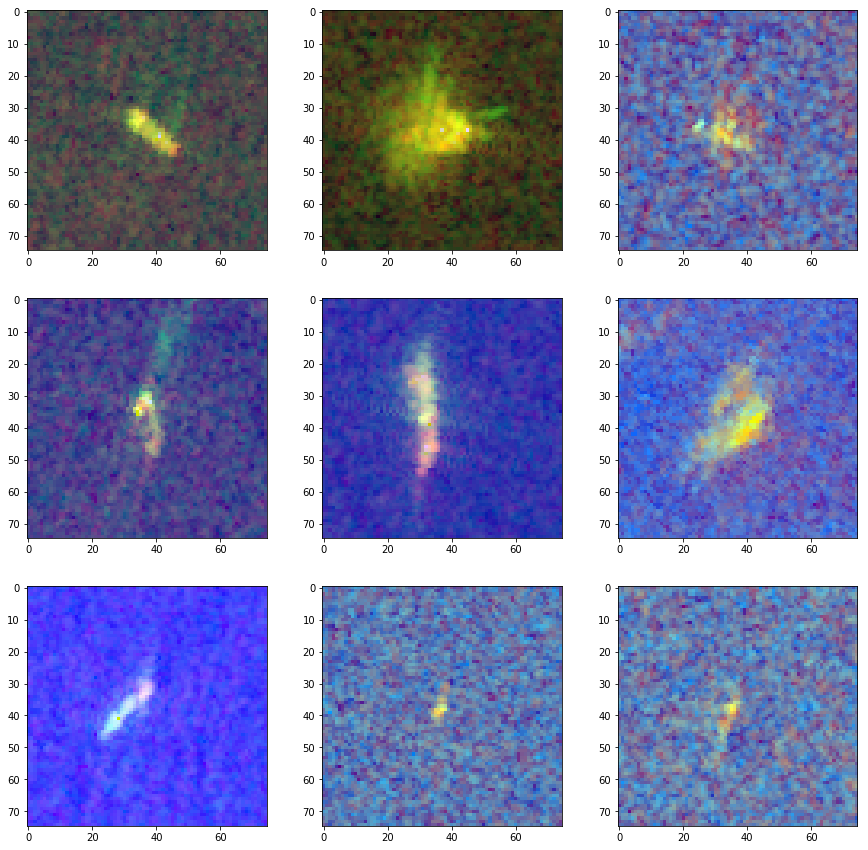

In [5]:
fig = plt.figure(200, figsize=(15, 15))
random_indicies = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indicies]
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

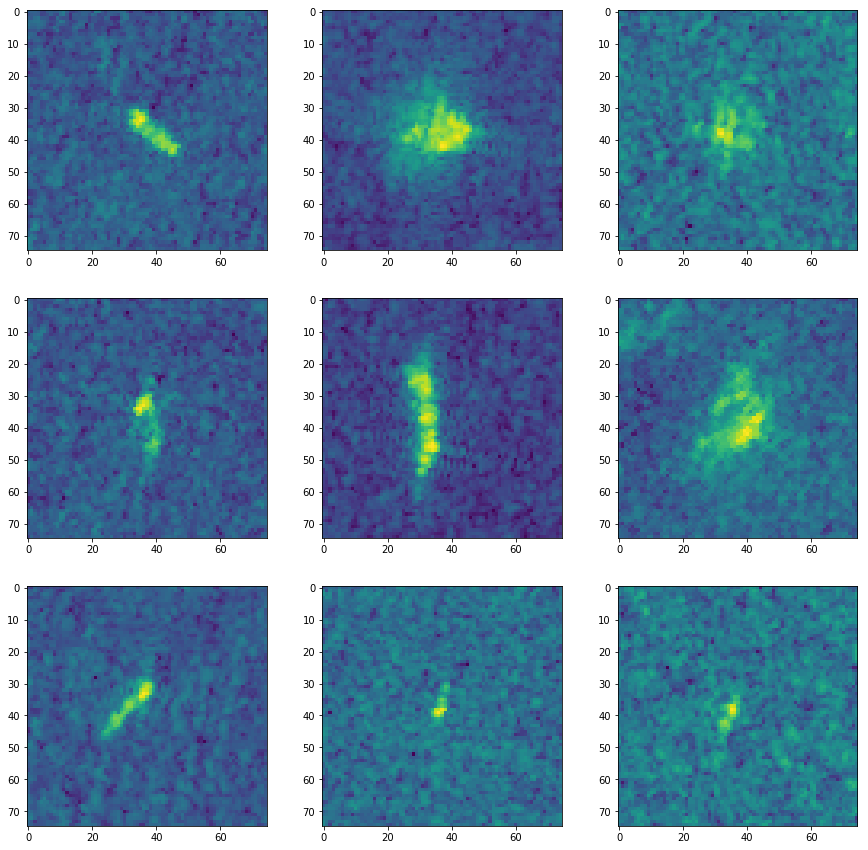

In [6]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

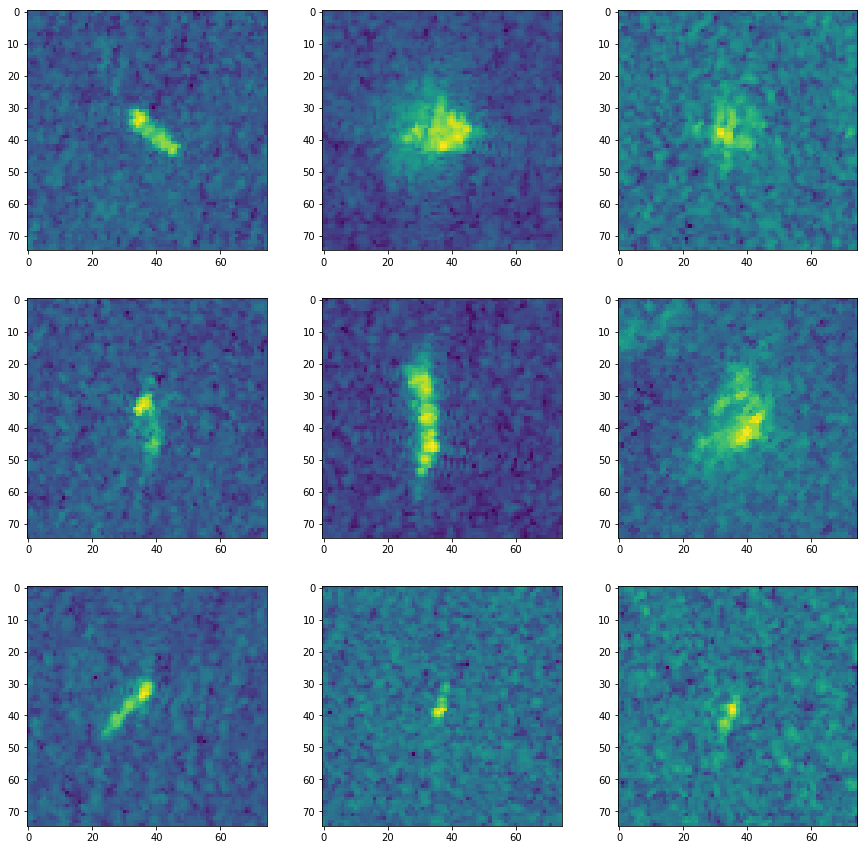

In [7]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

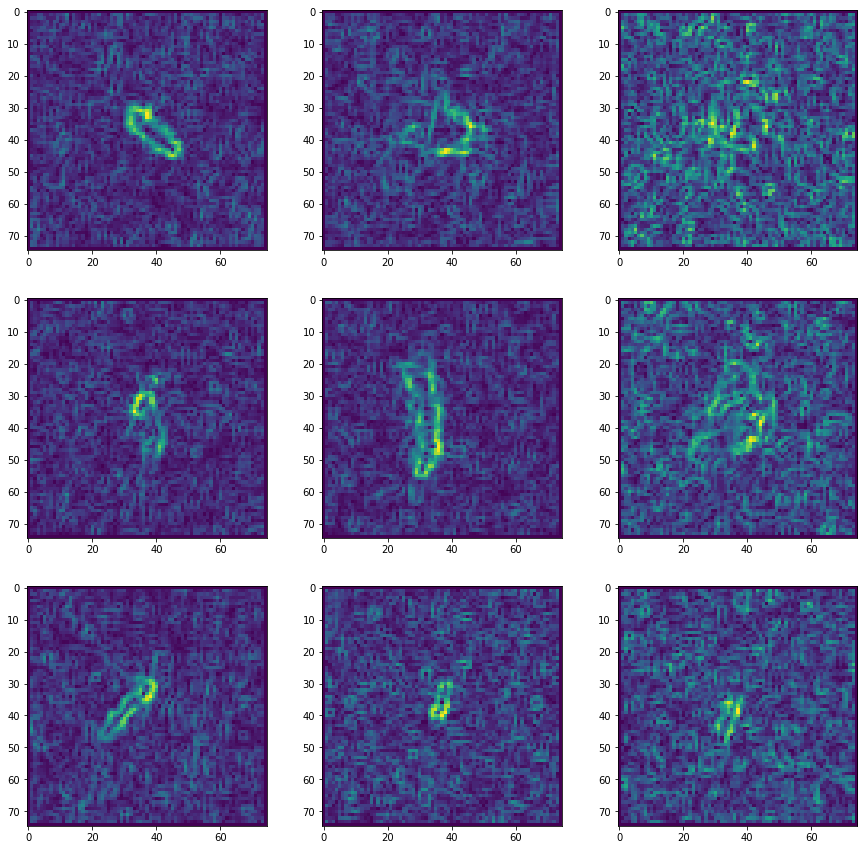

In [8]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

In [9]:
def get_model_notebook(lr, decay, channels, relu_type='relu'):
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    # For some reason i've decided not to normalize angle data
    output = Dense(1, activation="sigmoid")(dense)
    model = Model(local_input, output)
    optimizer = Adam(lr=lr, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model, partial_model

In [10]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    # I've never tested non-trainable source models tho
    #for layer in m_b.layers:
    #    layer.trainable = False
    #for layer in m_img.layers:
    #    layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    # So, combine models and train perceptron based on that
    # The iteresting idea is to use XGB for this task, but i actually hate this method
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation="sigmoid")(common)
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [11]:
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        #print I1i[0].shape
        np.testing.assert_array_equal(I2i[0], I1i[0])
        yield [I1i[0], I2i[1]], I1i[1]

In [12]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only=True, monitor='val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.,
                                   height_shift_range=0.,
                                   channel_shift_range=0,
                                   zoom_range=0.2,
                                   rotation_range=10)
    x_test, y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                                    steps_per_epoch=len(X_train) / batch_size,
                                    validation_data=(x_test, y_test), verbose=1,
                                    callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(filepath=checkpoint_name)
    return model

In [13]:
#Train a particular model
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                           X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                               verbose=0, batch_size=batch_size)

        loss_train, acc_train = model.evaluate(X_test, y_test,
                                       verbose=0, batch_size=batch_size)

        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
            'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [14]:
# Train all 3 models
def train_models(dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath='common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

In [ ]:
from jbeep import jbeep
jbeep.start()
# Best parameters i got are
# epochs : 250
# learning rate : 8e-5
# batch size : 32
common_model = train_models(dataset=(y_train, X_b, X_images), 
                            lr=7e-04, 
                            batch_size=32, 
                            max_epoch=50, 
                            verbose=1, 
                            return_model=True)

C:\Users\Bob\Anaconda3\envs\keras\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training bandwidth network
Epoch 1/50


In [ ]:
jbeep.end()

In [ ]:
%%javascript
Jupyter.beep();

In [278]:
if predict_submission:
    print('Reading test dataset')
    test = pd.read_json("test.json")
    y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
    print('Predicting')
    prediction = common_model.predict([X_fin_b, X_fin_img], verbose=1, batch_size=32)
    print('Submitting')
    submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
    submission.to_csv("test_submission.csv", index=False)
    print('Done')

Reading test dataset
Denoising and reshaping
RGB done
Predicting
8424/8424 [==============================] - 7s 791us/step
Submitting
Done


## Transfer Learning with VGG-16 CNN

In [10]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [11]:
train = pd.read_json("train.json")
target_train=train['is_iceberg']
test = pd.read_json("test.json")

In [15]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)



X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU, ThresholdedReLU
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input	

import VGG16PLUS
import VGG16CUSTOM
from jbeep import jbeep
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Lambda

#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

# Finally create generator
def get_callbacks(filepath, patience=2):
   es = EarlyStopping('val_loss', patience=10, mode="min")
   msave = ModelCheckpoint(filepath, save_best_only=True)
   return [es, msave]


def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16PLUS.VGG16PLUS(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(input=[base_model.input, input_2], output=predictions)
    
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

import matplotlib.pyplot as plt

#Using K-fold Cross Validation with Data Augmentation.
def myAngleCV(X_train, X_angle, X_test):
    K=3
    folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
    y_test_pred_log = 0
    y_train_pred_log=0
    y_valid_pred_log = 0.0*target_train
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\n===================FOLD=',j)
        X_train_cv = X_train[train_idx]
        y_train_cv = target_train[train_idx]
        X_holdout = X_train[test_idx]
        Y_holdout= target_train[test_idx]
        
        #Angle
        X_angle_cv=X_angle[train_idx]
        X_angle_hold=X_angle[test_idx]

        #define file path and get callbacks
        file_path = "%s_aug_model_weights.hdf5"%j
        callbacks = get_callbacks(filepath=file_path, patience=5)
        gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
        galaxyModel= getVggAngleModel()
        galaxyModel.fit_generator(
                gen_flow,
                steps_per_epoch=24,
                epochs=100,
                shuffle=True,
                verbose=1,
                validation_data=([X_holdout,X_angle_hold], Y_holdout),
                callbacks=callbacks)

        #Getting the Best Model
        galaxyModel.load_weights(filepath=file_path)
        #Getting Training Score
        score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
        print('Train loss:', score[0])
        print('Train accuracy:', score[1])
        #Getting Test Score
        score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        #Getting validation Score.
        pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
        y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

        #Getting Test Scores
        temp_test=galaxyModel.predict([X_test, X_test_angle])
        y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

        #Getting Train Scores
        temp_train=galaxyModel.predict([X_train, X_angle])
        y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

    y_test_pred_log=y_test_pred_log/K
    y_train_pred_log=y_train_pred_log/K

    print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
    print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
    scores.append([log_loss(target_train, y_train_pred_log),log_loss(target_train, y_valid_pred_log)])
    return y_train_pred_log

In [16]:
%%javascript
Jupyter.beep();

<IPython.core.display.Javascript object>

In [17]:
jbeep.start()

scores=[]
#for i in range(3):
preds=myAngleCV(X_train, X_angle, X_test)


===================FOLD= 0


C:\Users\Bob\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:109: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Epoch 1/100
24/24 [==============================] - 8s 330ms/step - loss: 1.6962 - acc: 0.5145 - val_loss: 0.6878 - val_acc: 0.5364
Epoch 2/100
24/24 [==============================] - 6s 237ms/step - loss: 0.8016 - acc: 0.5136 - val_loss: 0.6598 - val_acc: 0.6449
Epoch 3/100
24/24 [==============================] - 6s 231ms/step - loss: 0.6649 - acc: 0.6013 - val_loss: 0.4859 - val_acc: 0.7589
Epoch 4/100
24/24 [==============================] - 6s 240ms/step - loss: 0.5532 - acc: 0.7101 - val_loss: 0.3922 - val_acc: 0.8093
Epoch 5/100
24/24 [==============================] - 6s 232ms/step - loss: 0.4684 - acc: 0.7945 - val_loss: 0.3433 - val_acc: 0.8523
Epoch 6/100
24/24 [==============================] - 5s 228ms/step - loss: 0.4065 - acc: 0.8122 - val_loss: 0.3945 - val_acc: 0.8411
Epoch 7/100
24/24 [==============================] - 6s 234ms/step - loss: 0.3919 - acc: 0.8348 - val_loss: 0.2628 - val_acc: 0.8841
Epoch 8/100
24/24 [==============================] - 5s 227ms/step - 

In [18]:
jbeep.end()

Your code took 493.425491 seconds


In [19]:
%%javascript
Jupyter.beep();

<IPython.core.display.Javascript object>

In [20]:
submission = pd.DataFrame()
sample_submission = pd.read_csv("sample_submission.csv")
submission['id']=sample_submission['id']
submission['is_iceberg']=preds
submission.to_csv("selu.csv", index=False)

ValueError: Length of values does not match length of index

In [29]:
model1.shape, model4.shape

((8424, 2), (8424, 2))

In [33]:
import pandas as pd

model1 = pd.read_csv('transfer_0.95514.csv')
model2 = pd.read_csv('prewitt_0.931677.csv')
model3 = pd.read_csv("sobel_0.931677.csv")
model4 = pd.read_csv("selu.csv")
for column in sample_submission.columns:
    if column != 'id':
        sample_submission[column] = np.power((model1[column]*model2[column]*model3[column]*model4[column]), 1/4)
sample_submission.to_csv('geometric_ensemble2.csv', index=False)

In [10]:
scores

[[0.15382365176344365, 0.21681321837088954],
 [0.12635826119586002, 0.20735793218561654],
 [0.25422413761906343, 0.34938685475584597]]

In [6]:
VGG16CUSTOM.sayhi()

selu


In [17]:
train['pred']=pd.Series(preds)

In [19]:
train['output']=train['pred'] > 0.5

In [23]:
train['output'] = train['output'].astype(int)

Image # 724
Label: iceberg  Prediction: iceberg


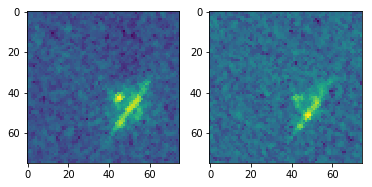

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

train = pd.read_json('output.json')
i = np.random.randint(1604)
img1 = np.array(train['band_1'].iloc[i]).astype(np.float32).reshape(75, 75)
img2 = np.array(train['band_2'].iloc[i]).astype(np.float32).reshape(75, 75)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img1)
axarr[1].imshow(img2)
print("Image # %d"% i)
if train['is_iceberg'].iloc[i] == 0 and train['output'].iloc[i] == 0:
    print("Label: ship  Prediction: ship")
elif train['is_iceberg'].iloc[i] == 0 and train['output'].iloc[i] == 1:
    print("Label: ship  Prediction: iceberg")
elif train['is_iceberg'].iloc[i] == 1 and train['output'].iloc[i] == 0:
    print("Label: iceberg  Prediction: ship")
elif train['is_iceberg'].iloc[i] == 1 and train['output'].iloc[i] == 1:
    print("Label: iceberg  Prediction: iceberg")
i += 1

In [6]:
train.to_json("output.json")